In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn
import torch
from datetime import datetime
import pandas as pd
from transformers import CLIPProcessor, CLIPModel, AutoImageProcessor, AutoModel, AutoTokenizer
import numpy as np

from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader, random_split, Subset


from pathlib import Path
from PIL import Image


## IMPORT

#### DATA

In [ ]:
!unzip "/content/drive/MyDrive/tinyvlm/data/image-description-marketplace-data.zip" -d "/content/flip_data_vlm"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_MX_SS40BTQ_1699.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_Mijia_Smart_Cooking_Machine_MPBJ001ACM_3824.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_Milkymoothie_4637.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_Mixy_Pro_4573.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_Mixy_Pro_Plus_4268.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_PBF01PBEU_голубой_5143.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_PHB_1399AL_5045.jpg  
  inflating: /content/flip_data_vlm/flip_data_vlm/flip_data_vlm/category_3/images/Блендер_PTB_0435_3864.jpg  


In [ ]:
all_products = pd.read_csv("/content/drive/MyDrive/tinyvlm/data/all_products_combined_translated.csv")
all_products = all_products.dropna()

In [ ]:
all_products.sample(10)

,Unnamed: 0,title,local_image_path,product_url,title_translated
16093,9477,Фигурка декоративная «Леди и будуар»,/root/flip/data/category_2/images/Фигурка_деко...,https://www.flip.kz/catalog?prod=2751600,"Decorative figure ""Lady and boudoir"""
6724,108,Брауни глазированный протеиновый без сахара «К...,/root/flip/data/category_1/images/Брауни_глази...,https://www.flip.kz/catalog?prod=3865087,"Browni glazed protein without sugar ""strawberr..."
11637,5021,"Коньки фигурные прокатные, белый, 35",/root/flip/data/category_1/images/Коньки_фигур...,https://www.flip.kz/catalog?prod=4122313,"Figure skates rolling, white, 35"
13793,7177,Фотоальбом «Цветочный узор»,/root/flip/data/category_2/images/Фотоальбом_Ц...,https://www.flip.kz/catalog?prod=2937865,"Photo album ""Flower pattern"""
14849,8233,"Полотенце махровое «Romance», розовый, 30×30 см",/root/flip/data/category_2/images/Полотенце_ма...,https://www.flip.kz/catalog?prod=1556272,"Terry towel ""Romance"", pink, 30 × 30 cm"
7965,1349,Жидкость от комаров «45 ночей»,/root/flip/data/category_1/images/Жидкость_от_...,https://www.flip.kz/catalog?prod=2450892,"Liquid from mosquitoes ""45 nights"""
23555,16939,Комплект насадок для пылесосов V7/V8/V10 для а...,/root/flip/data/category_3/images/Комплект_нас...,https://www.flip.kz/catalog?prod=3366379,A set of nozzles for vacuum cleaners V7/V8/V10...
2450,2450,Монитор XL2731K,/root/flip/data/category_4/images/Монитор_XL27...,https://www.flip.kz/catalog?prod=2660775,Monitor XL2731K
12775,6159,Ополаскиватель для посудомоечных машин,/root/flip/data/category_2/images/Ополаскивате...,https://www.flip.kz/catalog?prod=3579722,Rinse aircraft for dishwashers
16482,9866,Магнит на холодильник «Ангел»,/root/flip/data/category_2/images/Магнит_на_хо...,https://www.flip.kz/catalog?prod=2704220,"Magnet for the refrigerator ""Angel"""


In [ ]:
def is_valid_image_path(path):
    path_obj = Path(path)
    return path_obj.is_file() and not path_obj.is_dir()

def convert_to_colab_path(local_path):
    if local_path.startswith("/root/flip/data/"):
        return local_path.replace("/root/flip/data/", "/content/flip_data_vlm/flip_data_vlm/flip_data_vlm/")
    elif local_path.startswith("/flo_images/"):
        return local_path.replace("/flo_images/", "/content/flip_data_vlm/flip_data_vlm/flip_data_vlm/flo_images/")
    else:
        return ""  # or local_path

# Convert local paths to Colab-compatible ones
all_products["colab_image_path"] = (
    all_products["local_image_path"]
    .fillna("")
    .astype(str)
    .apply(convert_to_colab_path)
)

# Keep only rows with valid image paths
all_products = all_products[
    all_products["colab_image_path"].apply(is_valid_image_path)
]

In [ ]:
image_title_pairs = list(all_products[['colab_image_path','title_translated']].sample(frac=1, random_state=42, replace=False).itertuples(index=False, name=None))
len(image_title_pairs)

0

In [ ]:
class ImageTitleDataset(Dataset):

    def __init__(self, data):
        """
        data: list of tuples (image_path, text)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path, text = self.data[index]
        return image_path, text

In [ ]:
dataset = ImageTitleDataset(image_title_pairs)

In [ ]:
dataset[72]

IndexError: list index out of range

In [ ]:
general_dataloader = DataLoader(dataset, batch_size=512, shuffle=False)

#### CLIP

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## CLIP INFERENCE

In [ ]:

data = []

for batch_idx, (image_paths, texts) in enumerate(general_dataloader):

    # Load and process images
    images_processed = processor(
        images=[Image.open(p).convert("RGB") for p in image_paths],
        return_tensors="pt",
        padding=True
    ).to("cuda")

    # Process text
    texts_processed = processor(
        text=texts,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        image_features = model.get_image_features(**images_processed)
        text_features = model.get_text_features(**texts_processed)

    # Store per-sample entries
    for i, path in enumerate(image_paths):
        data.append({
            "image_path": path,
            "text": texts[i],                     # <-- store original text
            "image_embedding": image_features[i].cpu(),
            "text_embedding": text_features[i].cpu(),
        })

    print(f"Processed batch {batch_idx}/{len(general_dataloader)}")







Processed batch 0/56
Processed batch 1/56
Processed batch 2/56
Processed batch 3/56
Processed batch 4/56
Processed batch 5/56
Processed batch 6/56
Processed batch 7/56
Processed batch 8/56
Processed batch 9/56
Processed batch 10/56
Processed batch 11/56
Processed batch 12/56
Processed batch 13/56
Processed batch 14/56
Processed batch 15/56
Processed batch 16/56
Processed batch 17/56
Processed batch 18/56
Processed batch 19/56
Processed batch 20/56
Processed batch 21/56
Processed batch 22/56
Processed batch 23/56
Processed batch 24/56
Processed batch 25/56
Processed batch 26/56
Processed batch 27/56
Processed batch 28/56
Processed batch 29/56
Processed batch 30/56
Processed batch 31/56
Processed batch 32/56
Processed batch 33/56
Processed batch 34/56
Processed batch 35/56
Processed batch 36/56
Processed batch 37/56
Processed batch 38/56
Processed batch 39/56
Processed batch 40/56
Processed batch 41/56
Processed batch 42/56
Processed batch 43/56
Processed batch 44/56
Processed batch 45/5

In [ ]:
torch.save(data, "/content/drive/MyDrive/tinyvlm/data/image_paths_with_clip_embeddings.pt")

##### RELOAD DATA

In [ ]:
class ImageTitleWithClipDataset(Dataset):
    def __init__(self, data):
        """
        data: list of dicts with keys:
          - image_path
          - text
          - image_embedding (CLIP)
          - text_embedding (CLIP)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        return (
            item["image_path"],         # PIL image will be loaded in training loop
            item["text"],               # text
            item["image_embedding"],    # CLIP image embedding (tensor)
            item["text_embedding"]      # CLIP text embedding (tensor)
        )

In [ ]:
# Load the data from the .pt file
loaded_data = torch.load("/content/drive/MyDrive/tinyvlm/data/image_paths_with_clip_embeddings.pt")

# Initialize the dataset with the loaded data
dataset = ImageTitleWithClipDataset(loaded_data)

##### SAVE INDICIES

In [ ]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Save indices as a .pt file
torch.save({
    "train_indices": train_dataset.indices,
    "val_indices": val_dataset.indices
}, "/content/drive/MyDrive/tinyvlm/data/train_val_indices.pt")

##### RELOAD

In [ ]:
indices_dict = torch.load("/content/drive/MyDrive/tinyvlm/data/train_val_indices.pt")
train_indices = indices_dict["train_indices"]
val_indices = indices_dict["val_indices"]

# 3. Create Subsets using these indices
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

In [ ]:

train_dataloader = DataLoader(train_dataset, batch_size=180, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=180, shuffle=False)

In [ ]:
len(train_dataloader)

143

In [ ]:
image, text, image_embedding, text_embedding = train_dataset[92]

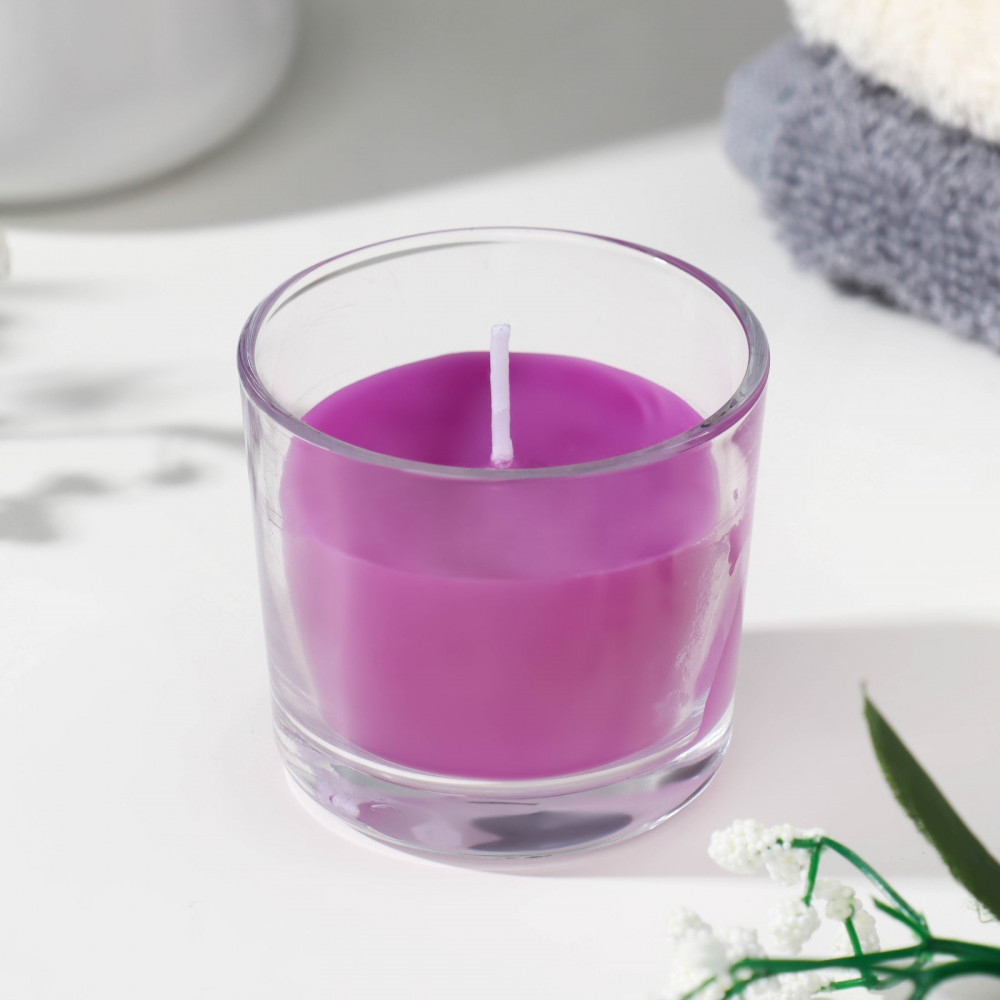

In [ ]:
Image.open(image)

In [ ]:
text

'Aromatic candle in a glass of "currant", currant'

## STUDENT MODEL BUILD

#### ARCHITECTURE

In [ ]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `tken` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate whe

In [ ]:
class DinoMiniLMDualEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Text encoder (MiniLM)
        self.text_encoder = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")
        self.text_tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L12-v2")

        # Image encoder (DINO)
        self.image_encoder = AutoModel.from_pretrained("facebook/dinov3-vits16-pretrain-lvd1689m")
        self.image_processor = AutoImageProcessor.from_pretrained("facebook/dinov3-vits16-pretrain-lvd1689m")

        # Projection layers
        self.image_projection = nn.Linear(in_features=384, out_features=512)
        self.text_projection = nn.Linear(in_features=384, out_features=512)

    def forward(self, image, text):
        device = next(self.parameters()).device  # model's device (cpu/cuda)

        # --- Text encoding ---
        text_inputs = self.text_tokenizer(
            text, return_tensors="pt", padding=True, truncation=True
        ).to(device)
        text_outputs = self.text_encoder(**text_inputs)
        text_embeddings = text_outputs.last_hidden_state.mean(dim=1)
        text_embeddings = self.text_projection(text_embeddings)

        # --- Image encoding ---
        image_processed = self.image_processor(images=image, return_tensors="pt").to(device)
        image_outputs = self.image_encoder(**image_processed)
        image_embeddings = self.image_projection(image_outputs.pooler_output)

        return text_embeddings, image_embeddings



In [ ]:
dino_minilm = DinoMiniLMDualEncoder().to('cuda')

In [ ]:
#### RELOAD WEIGHTS


dino_minilm = torch.load(
    "/content/drive/MyDrive/Data Science/tinyvlm/tinyvlm/models/dino_minilm_stage1.pth",
    map_location="cuda",
    weights_only=False
)




In [ ]:
sum(p.numel() for p in dino_minilm.parameters() if p.requires_grad == True)

41153536

In [ ]:
#### Freeze early layers

for parameter in dino_minilm.image_encoder.layer[0:4].parameters():
  parameter.requires_grad = False

for parameter in dino_minilm.text_encoder.encoder.layer[0:4].parameters():
  parameter.requires_grad = False

In [ ]:
sum(p.numel() for p in dino_minilm.parameters() if p.requires_grad == True)

41153536

In [ ]:
with torch.no_grad():

  #image = Image.open(train_dataset[42][0])


  x = dino_minilm( train_dataset[42][0],
                   train_dataset[42][1] )

#### TRAIN

##### LOSS

In [ ]:
import torch.nn.functional as F def contrastive_loss_with_clip_filtering( student_image_embeddings: torch.Tensor, student_text_embeddings: torch.Tensor, teacher_clip_text_embeddings: torch.Tensor, student_temperature: float = 0.07, similarity_threshold: float = 0.9 ): """ Contrastive Loss with Teacher-based Negative Filtering: - Student InfoNCE alignment only. - Filtering is done using fixed teacher CLIP text embeddings. """ # --- Normalize embeddings --- student_image_embeddings = F.normalize(student_image_embeddings, dim=-1) student_text_embeddings = F.normalize(student_text_embeddings, dim=-1) teacher_clip_text_embeddings = F.normalize(teacher_clip_text_embeddings, dim=-1) batch_size = student_image_embeddings.size(0) labels = torch.arange(batch_size, device=student_image_embeddings.device) # --- 1. Student similarity matrices --- sim_i2t_student = (student_image_embeddings @ student_text_embeddings.T) / student_temperature sim_t2i_student = sim_i2t_student.T # --- 2. Negative filtering using teacher embeddings --- cosine_similarity_matrix = teacher_clip_text_embeddings @ teacher_clip_text_embeddings.T mask_filter = cosine_similarity_matrix < similarity_threshold mask_filter.fill_diagonal_(True) # ✅ ensure mask is on same device as similarities mask_filter = mask_filter.to(sim_i2t_student.device) sim_i2t_student = sim_i2t_student.masked_fill(~mask_filter, float("-inf")) sim_t2i_student = sim_t2i_student.masked_fill(~mask_filter, float("-inf")) # --- 3. Contrastive loss (InfoNCE) --- loss_i2t = F.cross_entropy(sim_i2t_student, labels) loss_t2i = F.cross_entropy(sim_t2i_student, labels) contrastive_alignment_loss = (loss_i2t + loss_t2i) / 2 # --- 4. Stats --- total_negatives = batch_size * (batch_size - 1) kept_mask = mask_filter.clone() kept_mask.fill_diagonal_(False) negatives_kept = kept_mask.sum().item() negatives_filtered = total_negatives - negatives_kept stats = { "contrastive_loss": float(contrastive_alignment_loss.item()), "total_loss": float(contrastive_alignment_loss.item()), "negatives_kept": negatives_kept, "negatives_filtered": negatives_filtered, "negatives_total": total_negatives, } return contrastive_alignment_loss, stats





##### LOOP

In [ ]:
optimizer = torch.optim.Adam(dino_minilm.parameters(), lr=1e-5)

In [ ]:

val_losses = []
val_distill_losses = []

for epoch in range(50):
  dino_minilm.train()

  for batch_idx, (image_paths, texts, clip_image_embeddings, clip_text_embeddings) in enumerate(train_dataloader):

    clip_text_embeddings = clip_text_embeddings.to('cuda')

    pil_images = [Image.open(p).convert("RGB") for p in image_paths]

    optimizer.zero_grad()

    minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

    cf_loss, stats = contrastive_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                          student_text_embeddings = minilm_embeddings,
                                                          teacher_clip_text_embeddings = clip_text_embeddings)

    cf_loss.backward()

    optimizer.step()

    print(f'{datetime.now()} /// Epoch {epoch+1} {batch_idx+1}/{len(train_dataloader)} proocessed, STATS : {stats}')



  for image_paths, texts, clip_image_embeddings, clip_text_embeddings in val_dataloader:

    val_epoch_losses = []

    with torch.no_grad():
      pil_images = [Image.open(p).convert("RGB") for p in image_paths]

      clip_text_embeddings = clip_text_embeddings.to('cuda')

      minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

      cf_val_loss, stats = contrastive_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                student_text_embeddings = minilm_embeddings,
                                                                teacher_clip_text_embeddings = clip_text_embeddings)

      val_epoch_losses.append(cf_val_loss.item())


  val_losses.append(np.mean(val_epoch_losses))

  print(f'{datetime.now()} /// Epoch {epoch+1} Val CF Loss : {np.mean(val_epoch_losses)}')
















2025-10-05 16:17:19.412779 /// Epoch 1 1/143 proocessed, STATS : {'contrastive_loss': 5.325886249542236, 'total_loss': 5.325886249542236, 'negatives_kept': 32158, 'negatives_filtered': 62, 'negatives_total': 32220}
2025-10-05 16:17:26.369162 /// Epoch 1 2/143 proocessed, STATS : {'contrastive_loss': 5.279928207397461, 'total_loss': 5.279928207397461, 'negatives_kept': 32178, 'negatives_filtered': 42, 'negatives_total': 32220}
2025-10-05 16:17:34.096671 /// Epoch 1 3/143 proocessed, STATS : {'contrastive_loss': 5.309112071990967, 'total_loss': 5.309112071990967, 'negatives_kept': 32128, 'negatives_filtered': 92, 'negatives_total': 32220}
2025-10-05 16:17:40.127936 /// Epoch 1 4/143 proocessed, STATS : {'contrastive_loss': 5.315160751342773, 'total_loss': 5.315160751342773, 'negatives_kept': 32150, 'negatives_filtered': 70, 'negatives_total': 32220}
2025-10-05 16:17:46.964782 /// Epoch 1 5/143 proocessed, STATS : {'contrastive_loss': 5.218502044677734, 'total_loss': 5.218502044677734, 'n

KeyboardInterrupt: 

In [ ]:
#### CONTINUATION

val_losses = []

for epoch in range(50):
  dino_minilm.train()

  for batch_idx, (image_paths, texts, clip_image_embeddings, clip_text_embeddings) in enumerate(train_dataloader):

    clip_text_embeddings = clip_text_embeddings.to('cuda')

    pil_images = [Image.open(p).convert("RGB") for p in image_paths]

    optimizer.zero_grad()

    minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

    cf_loss, stats = contrastive_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                          student_text_embeddings = minilm_embeddings,
                                                          teacher_clip_text_embeddings = clip_text_embeddings)

    cf_loss.backward()

    optimizer.step()

    print(f'{datetime.now()} /// Epoch {epoch+1} {batch_idx+1}/{len(train_dataloader)} proocessed, STATS : {stats}')



  for image_paths, texts, clip_image_embeddings, clip_text_embeddings in val_dataloader:

    val_epoch_losses = []

    with torch.no_grad():
      pil_images = [Image.open(p).convert("RGB") for p in image_paths]

      clip_text_embeddings = clip_text_embeddings.to('cuda')

      minilm_embeddings, dino_embeddings = dino_minilm(pil_images, texts)

      cf_val_loss, stats = contrastive_loss_with_clip_filtering(student_image_embeddings = dino_embeddings,
                                                                student_text_embeddings = minilm_embeddings,
                                                                teacher_clip_text_embeddings = clip_text_embeddings)

      val_epoch_losses.append(cf_val_loss.item())


  val_losses.append(np.mean(val_epoch_losses))

  print(f'{datetime.now()} /// Epoch {epoch+1} Val CF Loss : {np.mean(val_epoch_losses)}')


2025-10-06 03:13:31.331597 /// Epoch 1 1/143 proocessed, STATS : {'contrastive_loss': 1.6710460186004639, 'total_loss': 1.6710460186004639, 'negatives_kept': 32166, 'negatives_filtered': 54, 'negatives_total': 32220}
2025-10-06 03:13:36.550610 /// Epoch 1 2/143 proocessed, STATS : {'contrastive_loss': 1.8621513843536377, 'total_loss': 1.8621513843536377, 'negatives_kept': 32176, 'negatives_filtered': 44, 'negatives_total': 32220}
2025-10-06 03:13:41.521600 /// Epoch 1 3/143 proocessed, STATS : {'contrastive_loss': 1.8884787559509277, 'total_loss': 1.8884787559509277, 'negatives_kept': 32154, 'negatives_filtered': 66, 'negatives_total': 32220}
2025-10-06 03:13:46.545366 /// Epoch 1 4/143 proocessed, STATS : {'contrastive_loss': 1.6151536703109741, 'total_loss': 1.6151536703109741, 'negatives_kept': 32074, 'negatives_filtered': 146, 'negatives_total': 32220}
2025-10-06 03:13:52.050453 /// Epoch 1 5/143 proocessed, STATS : {'contrastive_loss': 1.8088667392730713, 'total_loss': 1.808866739

KeyboardInterrupt: 

<Axes: >

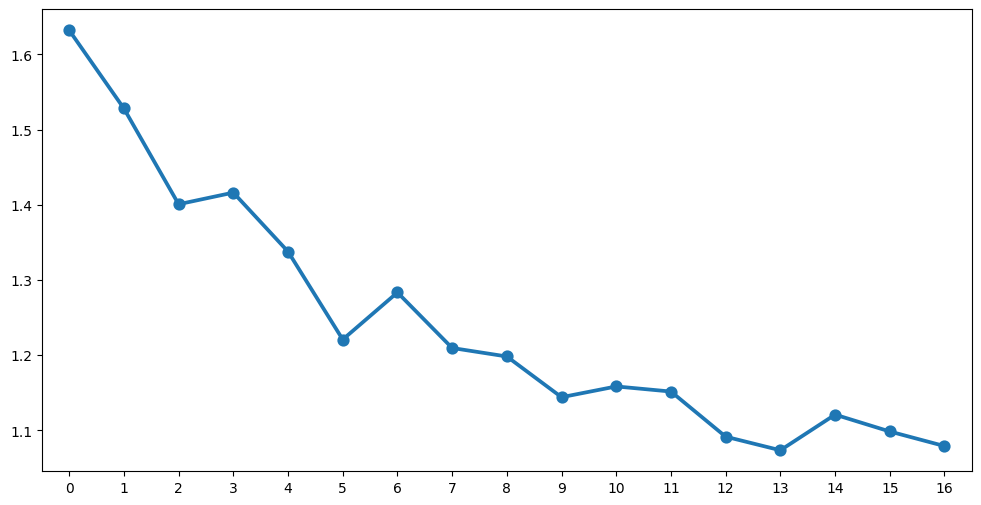

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))


sns.pointplot(data = val_losses)

In [ ]:
torch.save( dino_minilm.state_dict(), "/content/drive/MyDrive/Data Science/tinyvlm/tinyvlm/models/dino_minilm_stage1.pth" )